In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-state/lstm_NGSIM_col0.pt
/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy
/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy
/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy
/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy
/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy
/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy
/kaggle/input/follow-car-datasets/data/HighD_val_data.npy
/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy
/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy
/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy
/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy
/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy
/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy
/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy
/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy
/kaggle/input/follow-car-

(8779, 4, 375) (1880, 4, 375) (1881, 4, 375)
cuda:0


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


----


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train Loss: 0.1348993


 20%|██        | 1/5 [01:46<07:05, 106.32s/it]

Epoch: 1| Validation error: 0.1353321
Epoch: 2| Train Loss: 0.1335818


 40%|████      | 2/5 [03:32<05:18, 106.32s/it]

Epoch: 2| Validation error: 0.1362891
Epoch: 3| Train Loss: 0.1337093


 60%|██████    | 3/5 [05:19<03:33, 106.70s/it]

Epoch: 3| Validation error: 0.1358982
Epoch: 4| Train Loss: 0.1342510


 80%|████████  | 4/5 [07:06<01:46, 106.74s/it]

Epoch: 4| Validation error: 0.1389931
Epoch: 5| Train Loss: 0.1342535


100%|██████████| 5/5 [08:54<00:00, 106.81s/it]

Epoch: 5| Validation error: 0.1357345
Best Val Loss： 0.13533212745497966


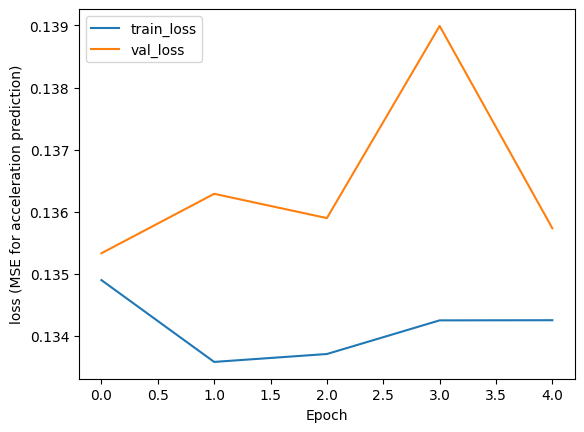

mean_test_error 206.20542697248788


1880it [09:29,  3.30it/s]


count= 1880 col= 295 rate 0.15691489361702127 jerk 5.3482305e-05 miniumu_ttc 163.11653
mean_test_error 76.20072776123966


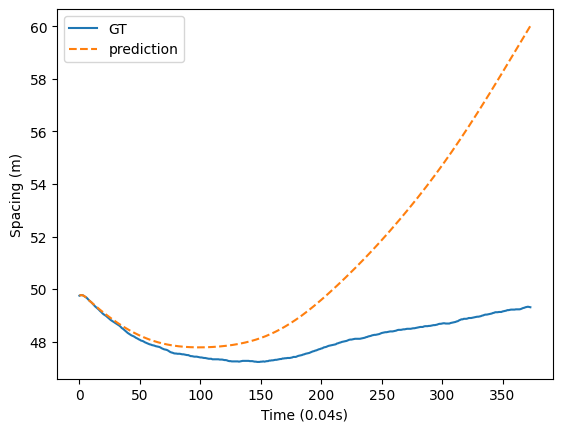

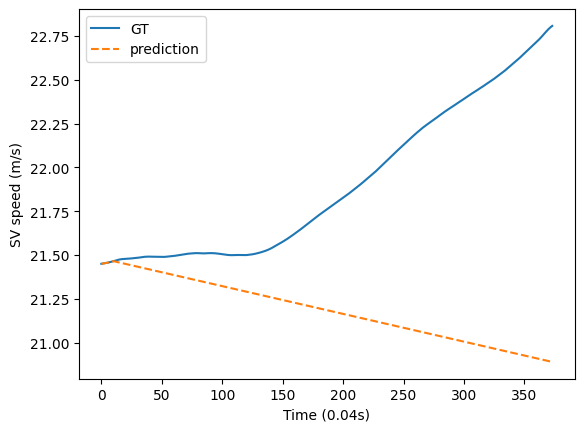

In [2]:
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial


ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
# Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
# car_following_data = HighD_data
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)数据形状格式（跟车事件的车辆数、4 维数据、各维数据的长度）
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]4 维数据= [车距、后车车速、相对车速、前车车速］
# print(car_following_data)
# print(car_following_data.shape)   # HighD(12541, 4, 375)

# split the date into train, validation, test 数据集划分
def split_train(data,test_ratio,val_ratio):
    np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    # 根据输入百分比（test_ratio）计算测试集大小
    test_set_size=int(len(data)*test_ratio)
    # 根据输入百分比（val_ratio）计算验证集大小
    val_number=int(len(data)*(test_ratio+val_ratio))
    # 根据索引划分数据集
    test_indices =shuffled_indices[:test_set_size] # 测试 (1881)
    val_indices=shuffled_indices[test_set_size:val_number] # 验证 (1881)
    train_indices=shuffled_indices[val_number:] # 训练 (8779)
    return data[train_indices],data[test_indices],data[val_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# Define NN and lstm models
max_len = 375 # for HighD dataset is 375 for others are 150
# max_len = 150

class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = max_len):
        if split == 'train':
            self.data = train_data
        elif split == 'test':
            self.data = test_data
        elif split == 'validation':
            self.data = val_data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的除最后一项的前 max_len-1 个时间步
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            )

    def forward(self, x):
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size=3, hidden_size=16, lstm_layers=1, dropout=0.1):
        super(lstm_model, self).__init__()
        # LSTM编码器，接受输入序列并输出隐藏状态
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
        # 线性层，将LSTM的输出映射到1维
        # self.linear = nn.Linear(hidden_size, 1)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.relu = nnn.ReLU(inplace=True)
        # 初始化线性层的权重和偏置
        nn.init.normal_(self.linear1.weight, 0, 0.02)
        nn.init.constant_(self.linear1.bias, 0.0)
        nn.init.normal_(self.linear2.weight, 0, 0.02)
        nn.init.constant_(self.linear2.bias, 0.0)
    # LSTM 模型由编码器和线性层组成。编码器接收输入数据并计算编码表示和最终层的隐藏状态。
    # 随后，线性层层将隐藏状态映射到输出值，输出值经过 tanh 激活函数并乘以代表加速度极限的常数
    def forward(self, src):
        # 将输入序列通过LSTM编码器得到隐藏状态  src(10,32,3)
        # enc_x(10,32,16)是模型在每个时间步的输出，(h_n, c_n)((1,32,16), (1,32,16))) 是模型的隐藏状态和记忆单元状态
        enc_x, (h_n, c_n) = self.encoder(src)
        # 如果隐藏状态的维度为3，则取最后一层的隐藏状态 即(batch_size, hidden_size)
        if len(h_n.shape) == 3:
            h_n = h_n[-1] # (32,16)
        # 通过线性层和激活函数得到最终输出
        out_0 = self.linear1(h_n) # (32,16)
        out = self.linear2(self.relu(out_0)) # (32, 1)
        # out = self.linear(h_n)
        # out = torch.tanh(out) * ACC_LIMIT
        return out


# Train
# 获取划分数据集
# (8779,4,375)，(1881,4,375)，(1881,4,375)
# train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# train_data, test_data, val_data = split_train(car_following_data,0.8,0.1)
train_data = HighD_train
test_data = HighD_test
val_data = HighD_val
# train_data = NGSIM_train
# test_data = NGSIM_test
# val_data = NGSIM_val
print(train_data.shape, test_data.shape, val_data.shape)
dataset = 'HighD'
model_type = 'lstm'
batch_size = 32
total_epochs = 5
# 创建训练集 DataLoader
train_dataset = ImitationCarFolData(split = 'train', max_len = max_len)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建验证集 DataLoader
validation_dataset = ImitationCarFolData(split = 'validation', max_len = max_len)
validation_loader = DataLoader(
        validation_dataset ,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建测试集 DataLoader
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)

# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

his_horizon = 10 # number of time steps as history data
# lr = 1e-3 # learning rate
lr = 0.1
save = f'{model_type}_{dataset}.pt' # 保存模型文件
# 根据名称定义模型
if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
# 定义优化器和损失函数
model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失


print("----")
# 训练过程
for epoch in tqdm(range(total_epochs)):
    train_losses = [] # 记录每个epoch的训练损失
    validation_losses = [] # 记录每个epoch的验证损失
    model.train()
    # 遍历数据集
    for i, item in enumerate(train_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(32,374)连接，转换成(3,32,374)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(374,32,3)，y->(374,32)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

        y_pre = torch.zeros(T - his_horizon, B).cuda() # 存储预测加速度 (364,32)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (364,32)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            # 根据his_horizon个数据预测加速度
            acc_pre = model(x).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = criterion(y_pre, y_label)
        model_optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25) # 对模型梯度进行裁剪，避免梯度爆炸
        model_optim.step()

        train_losses.append(loss.item())
    # 计算本轮平均损失
    train_loss = np.mean(train_losses)

    train_loss_his.append(train_loss)
    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

    # 验证过程
    model.eval()
    error_list = []
    for i, item in enumerate(validation_loader):
        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
        # lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        # save a copy of x_data
        x_data_orig = x_data.clone().detach()
        y_label = y_data[his_horizon:]
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data

            acc_pre = model(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre
        validation_loss = criterion(y_pre, y_label)
        model_optim.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        model_optim.step()
        validation_losses.append(validation_loss.item())
    # 计算平均验证误差
    mean_validation_error = np.mean(validation_losses)
    if best_validation_loss is None or best_validation_loss > mean_validation_error:
        best_validation_loss = mean_validation_error
        # save the best model
        with open(save, 'wb') as f:
            torch.save(model, f)

    validation_error_his.append(mean_validation_error)
    print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))

print("Best Val Loss：", best_validation_loss)
plt.plot(train_loss_his, label = 'train_loss')
plt.plot(validation_error_his, label = 'val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss (MSE for acceleration prediction)')
plt.show()


# 用该数据集训练得到的模型去对其他数据集进行测试
# Ts = 0.1
# max_len = 150
# # car_following_data = NGSIM_data
# # print(car_following_data.shape)
# # train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# test_data = NGSIM_test
# # 创建测试集 DataLoader
# test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
# test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=1,
#         drop_last=True)


# Testing, closed-loop prediction
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = criterion(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
# Ts = 0.1
# max_len = 150
batch_size = 1
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = [] 
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
            MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=MyDevice)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_) # 正常情况(139)
    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).cuda().cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)  # 大小为测试数据总数减去发生了碰撞的事件

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = criterion(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

(289, 4)
cuda:0
mean_test_error 452.5684577094184


289it [00:31,  9.28it/s]


count= 289 col= 107 rate 0.370242214532872 jerk 0.0003452615 miniumu_ttc 14.536358
mean_test_error 111.9706366917231


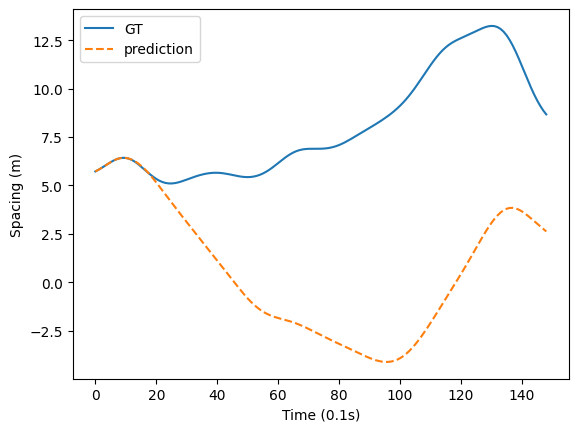

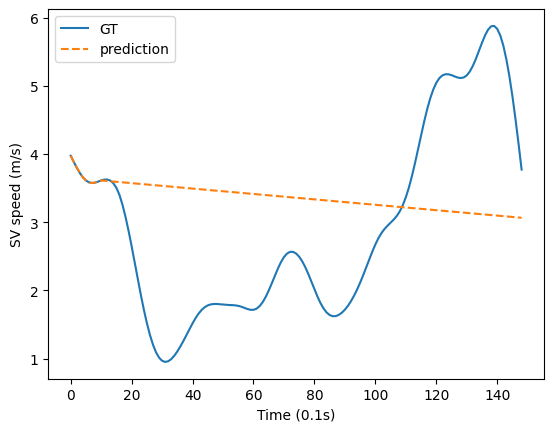

In [3]:
# 只含有test和指标计算代码部分，用于使用在不同数据集下训练的模型用在其他数据集上测试
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial


ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
# car_following_data = NGSIM_data
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)数据形状格式（跟车事件的车辆数、4 维数据、各维数据的长度）
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]4 维数据= [车距、后车车速、相对车速、前车车速］
# print(car_following_data)
# print(car_following_data.shape)   # (12541, 4, 375)

# # 除HighD的数据集需要进行连接
# def car_stack(data):
#     # 创建一个空的目标数组，形状为 (1930, 4, 600)
#     target_shape = (data.shape[0], data.shape[1], data[0, 0].shape[0])
#     target_array = np.empty(target_shape)

#     # 遍历原始数组，将每个元素转换为 (4, 600) 的子数组，并放入目标数组
#     for i in range(data.shape[0]):
#         for j in range(data.shape[1]):
#             target_array[i, j, :] = data[i, j]
#     # 最终 target_array 的形状为 (1930, 4, 600)
#     return target_array


# split the date into train, validation, test 数据集划分
def split_train(data,test_ratio,val_ratio):
    np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    # 根据输入百分比（test_ratio）计算测试集大小
    test_set_size=int(len(data)*test_ratio)
    # 根据输入百分比（val_ratio）计算验证集大小
    val_number=int(len(data)*(test_ratio+val_ratio))
    # 根据索引划分数据集
    test_indices =shuffled_indices[:test_set_size] # 测试 (1881)
    val_indices=shuffled_indices[test_set_size:val_number] # 验证 (1881)
    train_indices=shuffled_indices[val_number:] # 训练 (8779)
    return data[train_indices],data[test_indices],data[val_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# Define NN and lstm models
# max_len = 375 # for HighD dataset is 375 for others are 150
max_len = 150

class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = max_len):
        if split == 'train':
            self.data = train_data
        elif split == 'test':
            self.data = test_data
        elif split == 'validation':
            self.data = val_data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的除最后一项的前 max_len-1 个时间步
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            )

    def forward(self, x):
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size=3, hidden_size=16, lstm_layers=1, dropout=0.1):
        super(lstm_model, self).__init__()
        # LSTM编码器，接受输入序列并输出隐藏状态
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
        # 线性层，将LSTM的输出映射到1维
        # self.linear = nn.Linear(hidden_size, 1)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.relu = nnn.ReLU(inplace=True)
        # 初始化线性层的权重和偏置
        nn.init.normal_(self.linear1.weight, 0, 0.02)
        nn.init.constant_(self.linear1.bias, 0.0)
        nn.init.normal_(self.linear2.weight, 0, 0.02)
        nn.init.constant_(self.linear2.bias, 0.0)
    # LSTM 模型由编码器和线性层组成。编码器接收输入数据并计算编码表示和最终层的隐藏状态。
    # 随后，线性层层将隐藏状态映射到输出值，输出值经过 tanh 激活函数并乘以代表加速度极限的常数
    def forward(self, src):
        # 将输入序列通过LSTM编码器得到隐藏状态  src(10,32,3)
        # enc_x(10,32,16)是模型在每个时间步的输出，(h_n, c_n)((1,32,16), (1,32,16))) 是模型的隐藏状态和记忆单元状态
        enc_x, (h_n, c_n) = self.encoder(src)
        # 如果隐藏状态的维度为3，则取最后一层的隐藏状态 即(batch_size, hidden_size)
        if len(h_n.shape) == 3:
            h_n = h_n[-1] # (32,16)
        # 通过线性层和激活函数得到最终输出
        out_0 = self.linear1(h_n) # (32,16)
        out = self.linear2(self.relu(out_0)) # (32, 1)
        # out = self.linear(h_n)
        # out = torch.tanh(out) * ACC_LIMIT
        return out

HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)

# 获取划分数据集
# (8779,4,375)，(1881,4,375)，(1881,4,375)
# train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# train_data, test_data, val_data = Lyft_train, Lyft_test, Lyft_val
train_data = NGSIM_train
test_data = NGSIM_test
val_data = NGSIM_val
print(test_data.shape)
dataset = 'HighD'
model_type = 'lstm'
batch_size = 32
total_epochs = 20
# 创建训练集 DataLoader
train_dataset = ImitationCarFolData(split = 'train', max_len = max_len)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建验证集 DataLoader
validation_dataset = ImitationCarFolData(split = 'validation', max_len = max_len)
validation_loader = DataLoader(
        validation_dataset ,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建测试集 DataLoader
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)

# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

his_horizon = 10 # number of time steps as history data
lr = 1e-3 # learning rate
save = f'{model_type}_{dataset}.pt' # 保存模型文件
# 根据名称定义模型
if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
# 定义优化器和损失函数
model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失

# Testing, closed-loop prediction
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = criterion(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
batch_size = 1
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = [] 
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
            MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=MyDevice)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_)

    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).cuda().cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = criterion(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

In [4]:
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s   15/150s
max_len = 375 # for HighD dataset is 375 for others are 150

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True) # 151
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True) # 151
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True) # 151
NGSIM = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True) # 150
SPMD_DAS1 = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True) # 151
SPMD_DAS2 = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True) # 151
waymo = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True) # 150
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)数据形状格式（跟车事件的车辆数、4 维数据、各维数据的长度）
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]4 维数据= [车距、后车车速、相对车速、前车车速］

# 获取每个跟车事件的时间步长
def DataMin(dataset):
    data_min = []
    for i in range(dataset.shape[0]):
        data_min.append(dataset[i][0].size)
    return data_min

datamin = DataMin(waymo)
print(datamin)
print("最小时间步：", np.min(datamin))




[199, 198, 197, 199, 199, 198, 198, 198, 198, 199, 199, 199, 199, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 198, 199, 198, 198, 198, 199, 199, 199, 198, 199, 198, 198, 198, 198, 198, 198, 199, 198, 198, 199, 199, 199, 199, 198, 198, 198, 198, 198, 199, 199, 198, 198, 198, 198, 154, 157, 190, 198, 198, 198, 199, 199, 199, 199, 199, 167, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 166, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 169, 199, 199, 199, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 198, 198, 198, 199, 198, 199, 199, 199, 198, 198, 198, 198, 199, 198, 198, 199, 197, 197, 197, 198, 198, 198, 198, 198, 199, 199, 198, 198, 199, 198, 199, 199, 199, 198, 198, 198, 198, 198, 199, 198, 199, 198, 198, 199, 199, 199, 199, 198, 198, 198, 198, 199, 199, 198, 198, 199, 198, 198, 198, 199, 199, 199, 198, 198, 199, 199, 198, 198, 198, 198, 198, 198, 197, 197,

In [5]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# from collections import OrderedDict
# import matplotlib.pyplot as plt
# %matplotlib inline
# import copy

# device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # generating sinusoidal data
# # 生成正弦波数据的任务类
# class SineTask():
#   def __init__(self,amp,phase,min_x,max_x):
#     self.phase=phase  # 正弦波相位
#     self.max_x=max_x  # x的最大值
#     self.min_x=min_x  # x的最小值
#     self.amp=amp    # 正弦波振幅
#   # 生成任务数据，默认生成一个数据点，可以通过指定size参数生成多个数据点
#   def sample_data(self,size=1):
#     # 在指定范围内生成随机的x值
#     x=np.random.uniform(self.max_x,self.min_x,size)
#     # 根据生成的x值和任务的相位生成相应的正弦波y值
#     y=self.true_sine(x)
#     # 将生成的x和y转换为tensor
#     x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
#     y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
#     return x,y
#   # 根据给定的x值，计算相应的正弦波y值
#   def true_sine(self,x):
#     y=self.amp*np.sin(self.phase+x)
#     return y

# # 正弦任务分布
# class SineDistribution():
#   def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
#     self.min_amp=min_amp    # 最小振幅
#     self.max_phase=max_phase  # 最大相位
#     self.min_phase=min_phase  # 最小相位
#     self.max_amp=max_amp    # 最大振幅
#     self.min_x=min_x      # x的最小值
#     self.max_x=max_x      # x的最大值
#   # 从分布中随机生成一个正弦任务
#   def sample_task(self):
#     # 在最小振幅和最大振幅范围内生成随机的振幅
#     amp = np.random.uniform(self.min_amp, self.max_amp)
#     # 在最小相位和最大相位范围内生成随机的相位
#     phase = np.random.uniform(self.min_phase, self.max_phase)
#     # 返回一个新的正弦任务，使用生成的振幅、相位以及类初始化时传入的 x 的最小值和最大值
#     return SineTask(amp, phase, self.min_x, self.max_x)

# # defining our sine-net 定义模型
# class SineNet(nn.Module):
#   def __init__(self):
#     super(SineNet,self).__init__()
#     self.net=nn.Sequential(OrderedDict([
#             ('l1',nn.Linear(1,40)),
#             ('relu1',nn.ReLU()),
#             ('l2',nn.Linear(40,40)),
#             ('relu2',nn.ReLU()),
#             ('l3',nn.Linear(40,1))
#         ]))
      
#   # I implemented argforward() so that I could use a set of custom weights for evaluation. 
#   # This is important for the "inner loop" in MAML where you temporarily update the weights
#   # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
#   # 用于在元学习的内循环中使用自定义权重进行评估
#   def argforward(self,x,weights): 
#     x=F.linear(x,weights[0],weights[1])
#     x=F.relu(x)
#     x=F.linear(x,weights[2],weights[3])           
#     x=F.relu(x)
#     x=F.linear(x,weights[4],weights[5])
#     return x

# class SineMAML():
#   def __init__(self, net, alpha, beta, tasks, k, num_metatasks):
#     # 初始化 MAML 算法的元参数
#     self.net = net  # 元学习使用的神经网络模型
#     self.weights = list(net.parameters())  # 获取神经网络的参数
#     self.alpha = alpha  # 内循环学习率（内更新的学习率）
#     self.beta = beta  # 外循环学习率（外更新的学习率）
#     self.tasks = tasks  # 正弦任务的分布
#     self.k = k  # 内循环（任务采样）的数据集大小
#     self.num_tasks_meta = num_metatasks  # 外循环（元任务采样）的任务数量
#     self.criterion = nn.MSELoss()  # 均方误差损失函数
#     self.meta_optimiser = torch.optim.Adam(self.weights, self.beta)  # 外循环优化器（Adam）
#     self.meta_losses = []  # 用于存储元学习的损失历史
#     self.plot_every = 100  # 每隔多少次迭代记录一次损失，用于绘图
#     self.print_every = 10000  # 每隔多少次迭代输出一次损失信息，用于打印
#     self.num_metatasks = num_metatasks  # 外循环迭代的总次数

#   def inner_loop(self, task):
#     # 内循环更新参数，用于计算元学习损失
#     temp_weights = [w.clone() for w in self.weights]  # 复制当前网络参数作为临时参数
#     x, y = task.sample_data(size=self.k)  # 从任务中采样数据集 D
#     x = x.to(device)
#     y = y.to(device)
#     output = self.net.argforward(x, temp_weights)  # 使用临时参数进行前向传播
#     loss = self.criterion(output, y) / self.k  # 计算内循环损失
#     grads = torch.autograd.grad(loss, temp_weights)  # 计算损失对参数的梯度
#     temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grads)]  # 临时参数更新
#     x, y = task.sample_data(size=self.k)  # 从任务中采样数据集 D'
#     x = x.to(device)
#     y = y.to(device)
#     output = self.net.argforward(x, temp_weights)  # 使用更新后的参数进行前向传播
#     metaloss = self.criterion(output, y) / self.k  # 计算元学习损失
#     return metaloss

#   def outer_loop(self, num_epochs):
#     total_loss = 0
#     for epoch in range(1, num_epochs + 1):
#       metaloss_sum = 0
#       for i in range(self.num_metatasks):
#         task = self.tasks.sample_task()  # 从任务分布中采样一个元任务
#         metaloss = self.inner_loop(task)  # 内循环更新参数，计算元学习损失
#         metaloss_sum += metaloss
#       metagrads = torch.autograd.grad(metaloss_sum, self.weights)  # 计算元学习损失对参数的梯度
#       # 重要步骤：使用元学习梯度更新网络参数
#       for w, g in zip(self.weights, metagrads):
#         w.grad = g
#       self.meta_optimiser.step()  # 使用外循环优化器更新网络参数
#       total_loss += metaloss_sum.item() / self.num_metatasks
#       if epoch % self.print_every == 0:
#         print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
#       if epoch % self.plot_every == 0:
#         self.meta_losses.append(total_loss / self.plot_every)
#         total_loss = 0

# sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)
# net=SineNet()
# net=net.to(device)
# maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=5,num_metatasks=10)

# maml.outer_loop(num_epochs=50000)

# plt.plot(maml.meta_losses)

# def test(og_net,x,y,lr,optim=torch.optim.SGD):
#   axis=np.linspace(-5,5,1000)
#   axis=torch.tensor(axis,dtype=torch.float)
#   axis=axis.to(device)
#   dummy_net = nn.Sequential(OrderedDict([
#         ('l1', nn.Linear(1,40)),
#         ('relu1', nn.ReLU()),
#         ('l2', nn.Linear(40,40)),
#         ('relu2', nn.ReLU()),
#         ('l3', nn.Linear(40,1))
#     ]))
#   dummy_net=dummy_net.to(device)
#   dummy_net.load_state_dict(og_net.state_dict())
#   loss_fn=nn.MSELoss()
#   opt=optim(dummy_net.parameters(),lr=lr)
#   num_shots=10
#   k=x.shape[0]
#   losses=[]
#   outputs={}
#   for i in range(num_shots):
#     out=dummy_net(x)
#     loss=loss_fn(out,y)
#     losses.append(loss.item())
#     dummy_net.zero_grad()
#     loss.backward()
#     opt.step()
#   outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
#   outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
#   print(losses)
#   return outputs,axis

# def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
#   outputs,axis=test(og_net,x,y,lr,optim)
#   plt.figure(figsize=(10,5))
#   plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
#   plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
#   plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
#   plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
#   plt.legend(loc='lower right')
#   plt.show()

# K=10
# task=sine_tasks.sample_task()
# x,y=task.sample_data(K)
# x=x.to(device)
# y=y.to(device)
# plot_test(og_net=maml.net.net,x=x,y=y,task=task)